# Introducción: Comparación de Algoritmos sobre Fashion‑MNIST

**Integrantes:**
- Castrejón Bringas, Melanny Angeles
- Coronado Rodriguez, Augusto Takeshi
- Díaz Rodríguez, Carlo Franco
- Ramos Guerra, Ainhoa Jolie 

Este notebook documenta el trabajo práctico de la Unidad 3: comparar el desempeño de redes neuronales frente a algoritmos clásicos de Machine Learning en la clasificación de imágenes del dataset Fashion‑MNIST.

> **Nota:** en este proyecto, implementaremos únicamente el algoritmo clásico Naive Bayes (GaussianNB); las secciones de KNN, SVM y Random Forest quedan omitidas.

Objetivos principales
- Implementar y entrenar Naive Bayes (GaussianNB) y redes neuronales (Dense y CNN).
- Evaluar y comparar métricas (accuracy, precision, recall, F1) y tiempos de entrenamiento/predicción.
- Analizar errores por clase y presentar visualizaciones comparativas.

Dataset
- Fashion‑MNIST: imágenes en escala de grises 28×28, 60.000 muestras de entrenamiento y 10.000 de prueba, 10 clases (Camiseta/Top, Pantalón, Suéter, Vestido, Abrigo, Sandalia, Camisa, Zapatilla, Bolso, Botín).

Estructura del notebook
1. Preparación y exploración de datos: carga, visualización, normalización y aplanado para modelos clásicos (Naive Bayes) y redes neuronales.
2. Modelos clásicos: implementación y evaluación de Naive Bayes (GaussianNB) — baseline y mejoras recomendadas.
3. Redes neuronales: red densa y CNN (arquitecturas sugeridas), curvas de entrenamiento y evaluación final.
4. Análisis comparativo: tabla de métricas, análisis por clase y visualizaciones.
5. Conclusiones y recomendaciones.

Entregables y métricas
- Métricas: Accuracy, Precision (macro/micro), Recall (macro/micro), F1 (macro/micro).
- Entregables: código documentado, gráficas de entrenamiento, matrices de confusión, tabla comparativa de métricas y tiempos, y un breve reporte con conclusiones.

## Paso 0: Instalación e Importación de Librerias

### Instalación de Librerias y Dependencias

In [10]:
# Instalación de librerias y dependencias
# Usando uv (https://docs.astral.sh/uv/) como gestor de paquetes y versiones de python
!uv add --dev ipykernel uv
!uv add tensorflow keras pandas numpy seaborn matplotlib scikeras


Resolved 86 packages in 1ms
Audited 80 packages in 0.03ms
Resolved 86 packages in 1ms
Audited 54 packages in 0.09ms


### Importación y Configuración Inicial

In [11]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Configurar matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

print("Librerías importadas exitosamente!")
print(f" Versiones:")
print(f"   • TensorFlow: {tf.__version__}")
print(f"   • Keras: {keras.__version__}")

# Configurar reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

Librerías importadas exitosamente!
 Versiones:
   • TensorFlow: 2.20.0
   • Keras: 3.11.3


### Definicion de Clase de Datos Para Cada Modelo

In [12]:
from typing import Dict, Any, Optional, Union
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns

class ModelData:
    def __init__(
        self,
        model: Optional[BaseEstimator] = None,
        metrics: Optional[Dict[str, float]] = None,
        X_test: Optional[np.ndarray] = None,
        y_test: Optional[np.ndarray] = None
    ):
        """
        Clase para almacenar datos de modelos y métricas, con capacidad de generar visualizaciones bajo demanda.
        
        Args:
            model: Objeto del modelo (NaiveBayes, Dense Network, CNN, etc.)
            metrics: Diccionario de métricas de evaluación
            X_test: Datos de prueba para generar visualizaciones
            y_test: Etiquetas verdaderas para generar visualizaciones
        """
        self.model = model
        self.metrics = metrics or {}
        self.plots: Dict[str, plt.Figure] = {}  # Ahora se generan bajo demanda
        self.X_test = X_test
        self.y_test = y_test

    def generate_confusion_matrix(self) -> plt.Figure:
        """Genera y almacena la matriz de confusión"""
        if self.model is None or self.X_test is None or self.y_test is None:
            raise ValueError("Modelo o datos de prueba no disponibles")
            
        y_pred = self.model.predict(self.X_test)
        fig, ax = plt.subplots(figsize=(10, 8))
        ConfusionMatrixDisplay.from_predictions(
            self.y_test, 
            y_pred,
            ax=ax,
            cmap='Blues',
            colorbar=False
        )
        ax.set_title('Matriz de Confusión')
        self.plots['confusion_matrix'] = fig
        return fig

    def generate_class_report(self) -> plt.Figure:
        """Genera y almacena un reporte por clase"""
        if self.metrics.get('class_report') is None:
            raise ValueError("Reporte por clase no disponible en las métricas")
            
        # Implementación de la visualización del reporte por clase
        fig = plt.figure(figsize=(10, 6))
        # ... código para generar el gráfico ...
        self.plots['class_report'] = fig
        return fig

    def generate_all_plots(self) -> None:
        """Genera todos los plots disponibles automáticamente"""
        try:
            self.generate_confusion_matrix()
        except Exception as e:
            print(f"No se pudo generar matriz de confusión: {e}")
            
        try:
            self.generate_class_report()
        except Exception as e:
            print(f"No se pudo generar reporte por clase: {e}")

# Array vacío para almacenar objetos ModelData
model_results: list[ModelData] = []

## Paso 1: Preparación y Exploración de Datos

Actividades principales:

1. Carga y exploración inicial
   - Cargar el dataset Fashion‑MNIST desde `keras.datasets.fashion_mnist`.
   - Mostrar tamaño de los conjuntos de entrenamiento y prueba.
   - Visualizar muestras representativas de cada una de las 10 clases.
   - Analizar la distribución de clases y detectar desequilibrios.

2. Preprocesamiento
   - Normalizar los píxeles a rango [0, 1].
   - Aplanar imágenes a vectores de 784 dimensiones para los modelos clásicos.
   - Preparar one‑hot encodings y partición train/validation para redes neuronales.

Entregables:
- Gráficos de muestras por clase.
- Estadísticas básicas (shape, distribución de clases).
- Código claramente documentado para el preprocesamiento.

### Carga y Exploración de Datos

Cargando dataset Fashion MNIST...
Dataset cargado exitosamente!
Información del dataset:
------------------------
   • Datos de entrenamiento: (60000, 28, 28)
   • Etiquetas de entrenamiento: (60000,)
   • Datos de prueba: (10000, 28, 28)
   • Etiquetas de prueba: (10000,)
Propiedades básicas:
--------------------
   • Tipo de datos: uint8
   • Rango de valores: 0 - 255
   • Forma de una imagen: (28, 28)
   • Clases únicas: [0 1 2 3 4 5 6 7 8 9]

 Distribución de clases en entrenamiento:
     Prenda 0: 6,000 ejemplos
     Prenda 1: 6,000 ejemplos
     Prenda 2: 6,000 ejemplos
     Prenda 3: 6,000 ejemplos
     Prenda 4: 6,000 ejemplos
     Prenda 5: 6,000 ejemplos
     Prenda 6: 6,000 ejemplos
     Prenda 7: 6,000 ejemplos
     Prenda 8: 6,000 ejemplos
     Prenda 9: 6,000 ejemplos


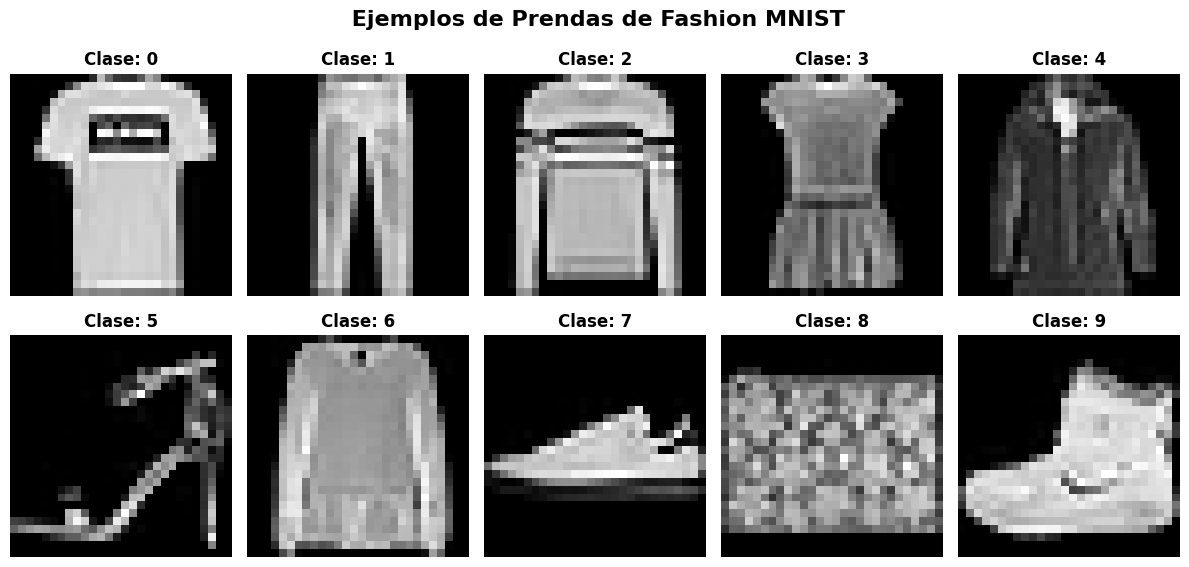

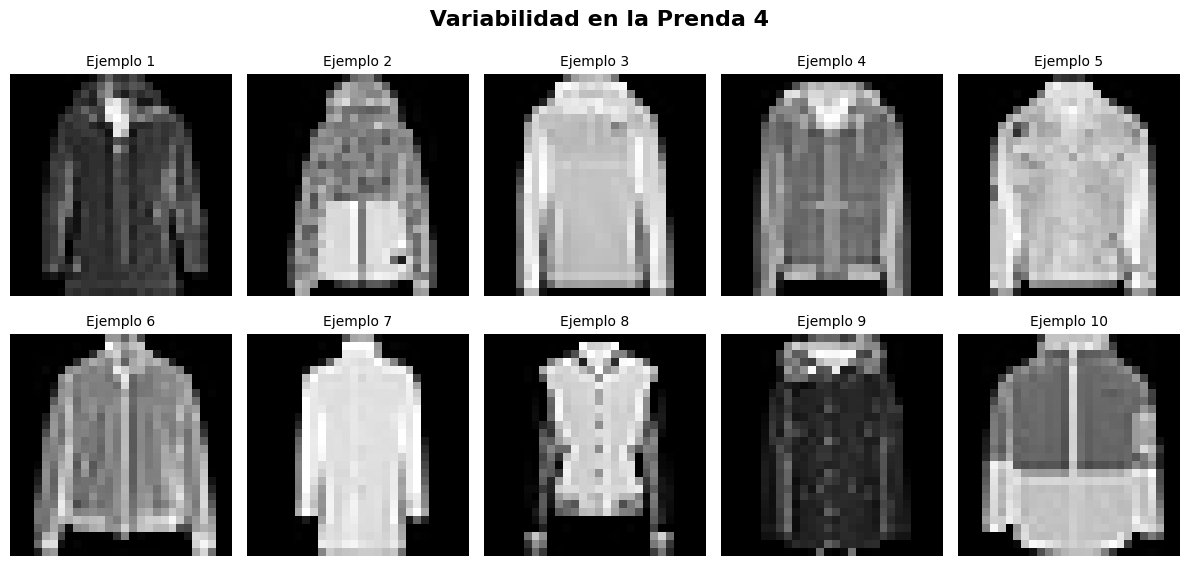

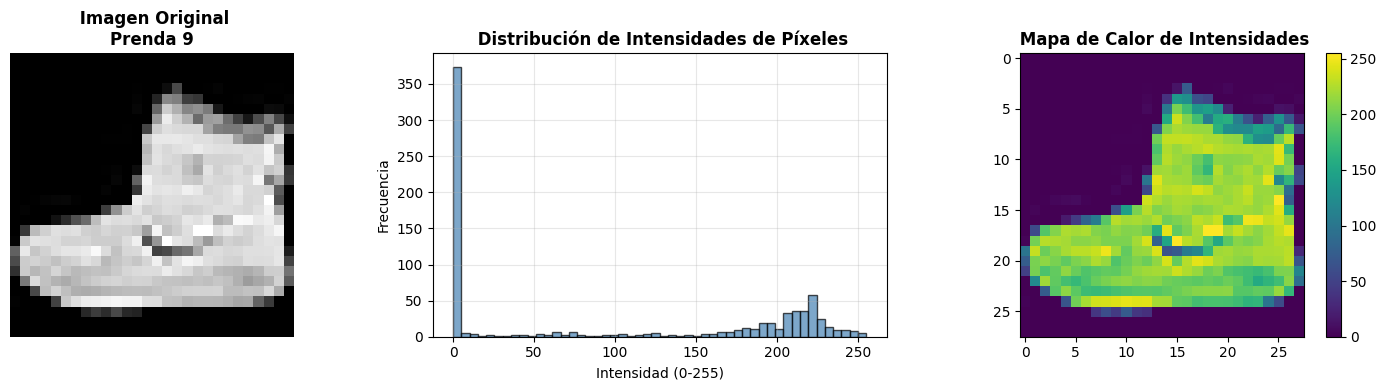

 Estadísticas de la Imagen de la Prenda 9:
   • Media: 97.25
   • Desviación estándar: 101.79
   • Píxeles no-cero: 433 de 784
   • Porcentaje de píxeles activos: 55.2%


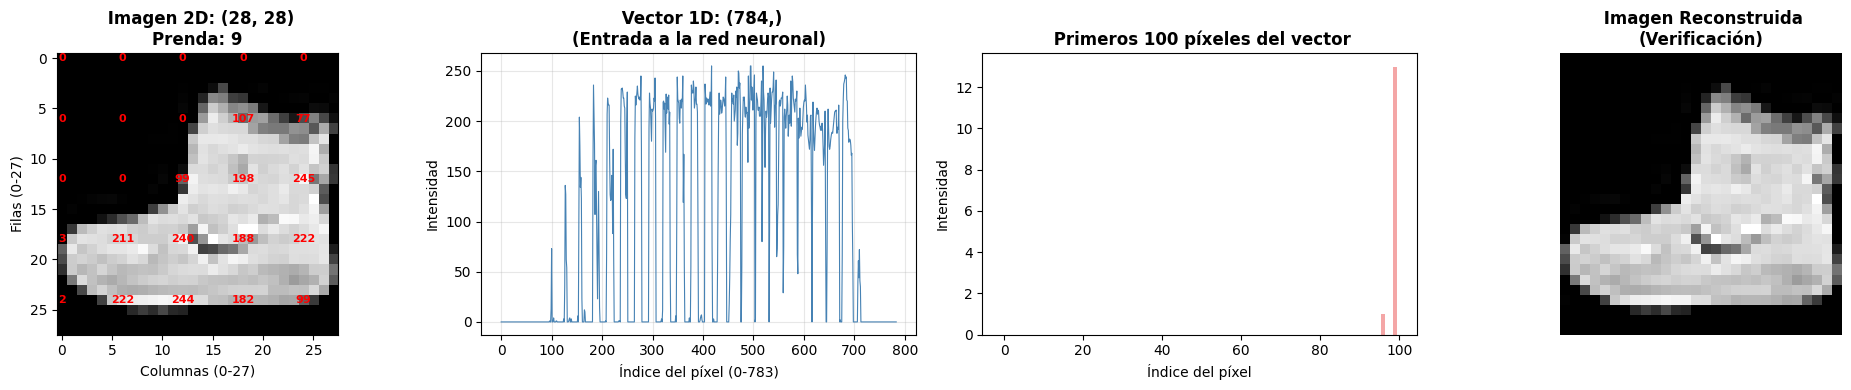

 ANÁLISIS DEL PROCESO:
   1. Imagen original: matriz de (28, 28)
   2. Aplanada: vector de (784,)
   3. Cada píxel representa la intensidad en esa posición
   4. La red neuronal verá estos 784 números como entrada
   5. Debe aprender a reconocer patrones en estos 784 valores


In [13]:
# Paso 1 — Preparación y Exploración de Datos (bloque ejecutable limpio)
# Carga, visualización, normalización, aplanado y partición train/validation
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split

# Cargar datos MNIST
print("Cargando dataset Fashion MNIST...")
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Dataset cargado exitosamente!")
print("========================================")
print(f"Información del dataset:")
print("------------------------")
print(f"   • Datos de entrenamiento: {X_train.shape}")
print(f"   • Etiquetas de entrenamiento: {y_train.shape}")
print(f"   • Datos de prueba: {X_test.shape}")
print(f"   • Etiquetas de prueba: {y_test.shape}")

# Explorar propiedades básicas del dataset
print("========================================")
print(f"Propiedades básicas:")
print("--------------------")
print(f"   • Tipo de datos: {X_train.dtype}")
print(f"   • Rango de valores: {X_train.min()} - {X_train.max()}")
print(f"   • Forma de una imagen: {X_train[0].shape}")
print(f"   • Clases únicas: {np.unique(y_train)}")

# Contar ejemplos por clase
unique, counts = np.unique(y_train, return_counts=True)
print(f"\n Distribución de clases en entrenamiento:")
for clothing, count in zip(unique, counts):
    print(f"     Prenda {clothing}: {count:,} ejemplos")

###  Visualización de Ejemplos por Prenda

# Visualizar ejemplos de cada dígito (0-9)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle(' Ejemplos de Prendas de Fashion MNIST', fontsize=16, fontweight='bold')

for clothing in range(10):
    # Encontrar el primer ejemplo de cada clase
    idx = np.where(y_train == clothing)[0][0]
    row, col = clothing // 5, clothing % 5

    axes[row, col].imshow(X_train[idx], cmap='gray')
    axes[row, col].set_title(f'Clase: {clothing}', fontsize=12, fontweight='bold')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Variabilidad Intra-Clase

# Mostrar múltiples ejemplos del mismo dígito para ver variabilidad
cloth_to_analyze = 4  # Cambiar por cualquier dígito 0-9
indices = np.where(y_train == cloth_to_analyze)[0][:10]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle(f' Variabilidad en la Prenda {cloth_to_analyze}', fontsize=16, fontweight='bold')

for i, idx in enumerate(indices):
    row, col = i // 5, i % 5
    axes[row, col].imshow(X_train[idx], cmap='gray')
    axes[row, col].set_title(f'Ejemplo {i+1}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

###  Análisis de Intensidad de Píxeles

# Analizar la distribución de intensidades de píxeles
sample_image = X_train[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Imagen original
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f' Imagen Original\nPrenda {y_train[0]}', fontweight='bold')
axes[0].axis('off')

# Histograma de intensidades
axes[1].hist(sample_image.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].set_title(' Distribución de Intensidades de Píxeles', fontweight='bold')
axes[1].set_xlabel('Intensidad (0-255)')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, alpha=0.3)

# Mapa de calor 3D de la imagen
im = axes[2].imshow(sample_image, cmap='viridis')
axes[2].set_title(' Mapa de Calor de Intensidades', fontweight='bold')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

# Mostrar estadísticas de la imagen
print(f" Estadísticas de la Imagen de la Prenda {y_train[0]}:")
print(f"   • Media: {sample_image.mean():.2f}")
print(f"   • Desviación estándar: {sample_image.std():.2f}")
print(f"   • Píxeles no-cero: {np.count_nonzero(sample_image):,} de {sample_image.size:,}")
print(f"   • Porcentaje de píxeles activos: {np.count_nonzero(sample_image)/sample_image.size*100:.1f}%")

### Visualización de la Transformación 2D → 1D

# Mostrar cómo se convierte una imagen 2D en vector 1D
sample_idx = 0
sample_image = X_train[sample_idx]
sample_label = y_train[sample_idx]

fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# Imagen original 28x28
axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f' Imagen 2D: {sample_image.shape}\nPrenda: {sample_label}', fontweight='bold')
axes[0].set_xlabel('Columnas (0-27)')
axes[0].set_ylabel('Filas (0-27)')

# Mostrar algunos valores de píxeles
for i in range(0, 28, 6):
    for j in range(0, 28, 6):
        axes[0].text(j, i, f'{sample_image[i,j]:.0f}',
                    ha='center', va='center', color='red', fontsize=8, fontweight='bold')

# Vector 1D
flattened = sample_image.flatten()
axes[1].plot(flattened, linewidth=0.8, color='steelblue')
axes[1].set_title(f' Vector 1D: {flattened.shape}\n(Entrada a la red neuronal)', fontweight='bold')
axes[1].set_xlabel('Índice del píxel (0-783)')
axes[1].set_ylabel('Intensidad')
axes[1].grid(True, alpha=0.3)

# Mostrar las primeras 100 componentes del vector
axes[2].bar(range(100), flattened[:100], width=1.0, color='lightcoral', alpha=0.7)
axes[2].set_title(' Primeros 100 píxeles del vector', fontweight='bold')
axes[2].set_xlabel('Índice del píxel')
axes[2].set_ylabel('Intensidad')

# Reconstruir la imagen desde el vector para verificar
reconstructed = flattened.reshape(28, 28)
axes[3].imshow(reconstructed, cmap='gray')
axes[3].set_title(' Imagen Reconstruida\n(Verificación)', fontweight='bold')
axes[3].axis('off')

plt.tight_layout()
plt.show()

print(" ANÁLISIS DEL PROCESO:")
print(f"   1. Imagen original: matriz de {sample_image.shape}")
print(f"   2. Aplanada: vector de {flattened.shape}")
print(f"   3. Cada píxel representa la intensidad en esa posición")
print(f"   4. La red neuronal verá estos {len(flattened)} números como entrada")
print(f"   5. Debe aprender a reconocer patrones en estos {len(flattened)} valores")


### Preprocesamiento de Datos

 PREPROCESAMIENTO DE DATOS:
   Antes de normalizar - Rango: [0, 255]
   Después de normalizar - Rango: [0.000, 1.000]


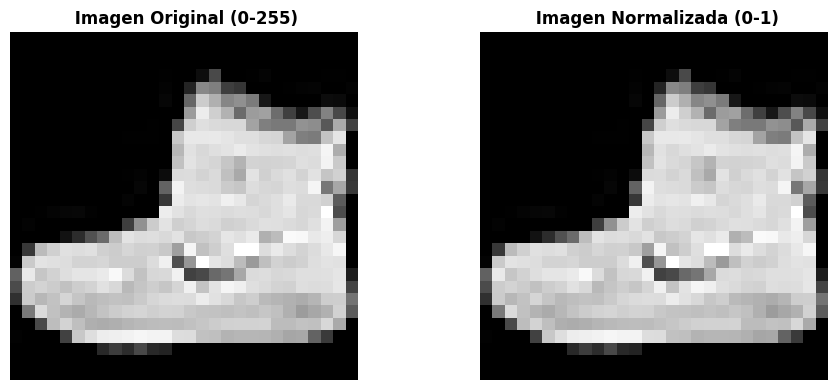


 TRANSFORMACIÓN DE FORMA:
   X_train original: (60000, 28, 28)
   X_train_flat: (60000, 784)
   Cada imagen 28×28 = 784 píxeles se convierte en vector de 784 elementos

  CODIFICACIÓN ONE-HOT:
   y_train original shape: (60000,)
   y_train_onehot shape: (60000, 10)

   Ejemplos de codificación one-hot:
     Prenda 9 → [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
     Prenda 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     Prenda 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
     Prenda 3 → [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
     Prenda 0 → [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


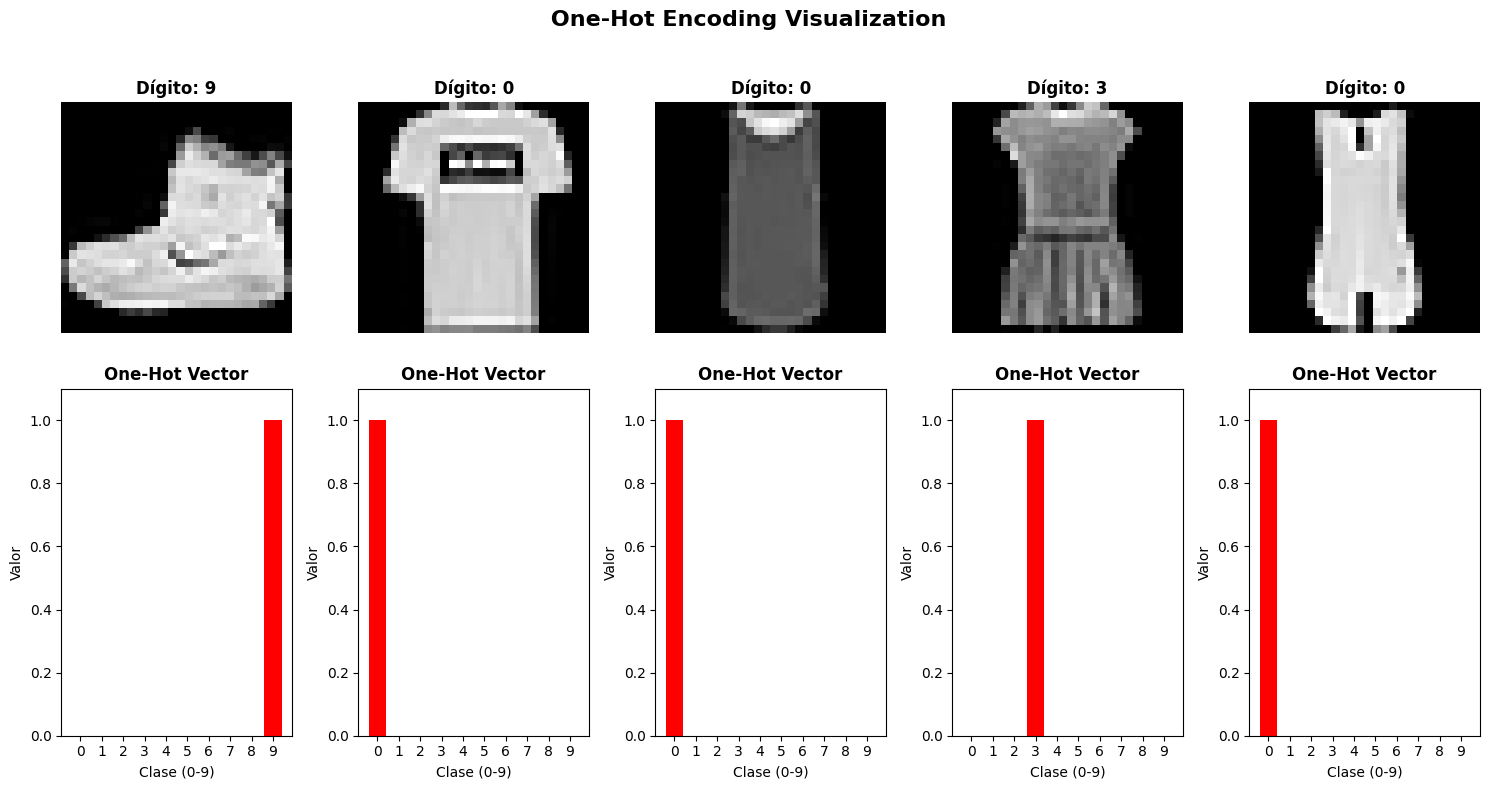

In [14]:
# Normalizar píxeles a rango [0,1]
print(" PREPROCESAMIENTO DE DATOS:")
print(f"   Antes de normalizar - Rango: [{X_train.min()}, {X_train.max()}]")

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"   Después de normalizar - Rango: [{X_train.min():.3f}, {X_train.max():.3f}]")

# Visualizar el efecto de la normalización
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Imagen sin normalizar (recreada para visualización)
original_image = (X_train[0] * 255).astype('uint8')
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title(' Imagen Original (0-255)', fontweight='bold')
axes[0].axis('off')

# Imagen normalizada
axes[1].imshow(X_train[0], cmap='gray')
axes[1].set_title(' Imagen Normalizada (0-1)', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Aplanar imágenes de 28x28 a vector 784x1
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # (60000, 784)
X_test_flat = X_test.reshape(X_test.shape[0], -1)     # (10000, 784)

print(f"\n TRANSFORMACIÓN DE FORMA:")
print(f"   X_train original: {X_train.shape}")
print(f"   X_train_flat: {X_train_flat.shape}")
print(f"   Cada imagen 28×28 = {28*28} píxeles se convierte en vector de 784 elementos")

# Convertir etiquetas a codificación one-hot
y_train_onehot = np.eye(10)[y_train]  # (60000, 10)
y_test_onehot = np.eye(10)[y_test]    # (10000, 10)

print(f"\n  CODIFICACIÓN ONE-HOT:")
print(f"   y_train original shape: {y_train.shape}")
print(f"   y_train_onehot shape: {y_train_onehot.shape}")

# Mostrar ejemplos de one-hot encoding
print("\n   Ejemplos de codificación one-hot:")
for i in range(5):
    print(f"     Prenda {y_train[i]} → {y_train_onehot[i]}")

###  Visualización One-Hot Encoding

# Visualizar el concepto de one-hot
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle(' One-Hot Encoding Visualization', fontsize=16, fontweight='bold')

for i in range(5):
    # Mostrar imagen
    axes[0, i].imshow(X_train[i], cmap='gray')
    axes[0, i].set_title(f'Dígito: {y_train[i]}', fontweight='bold')
    axes[0, i].axis('off')

    # Mostrar codificación one-hot como barras
    bars = axes[1, i].bar(range(10), y_train_onehot[i],
                         color=['red' if j == y_train[i] else 'lightblue' for j in range(10)])
    axes[1, i].set_title('One-Hot Vector', fontweight='bold')
    axes[1, i].set_xlabel('Clase (0-9)')
    axes[1, i].set_ylabel('Valor')
    axes[1, i].set_ylim(0, 1.1)
    axes[1, i].set_xticks(range(10))

plt.tight_layout()
plt.show()

## Parte 2: Algoritmos Clásicos

Implementación específica para este grupo:

- Naive Bayes (GaussianNB) — Implementar y evaluar como baseline.
  - Entrenar con los vectores aplanados.
  - Explorar preprocesados recomendados: escalado (StandardScaler/MinMax), PCA (50–200 componentes) y búsquedas de `var_smoothing`.
  - Evaluar tiempos de entrenamiento y predicción.
  - Generar matriz de confusión y reporte de clasificación.

Se omiten las implementaciones directas de KNN, SVM y Random Forest por alcance de grupo; se pueden mantener notas y celdas comentadas para referencia.

Entregables para esta parte:
- Código entrenando GaussianNB sobre los datos aplanados.
- Matriz de confusión y métricas (accuracy, precision, recall, F1‑score).
- Análisis de preprocesamiento y tiempos.

### Mejoras recomendadas — GaussianNB (baseline)

- Preprocesado: escalar/normalizar las features (StandardScaler o MinMax); eliminar ruido y outliers.
- Reducir dimensionalidad con PCA/TruncatedSVD (50–200 componentes) para quitar redundancia.
- Selección de features (VarianceThreshold, SelectKBest) si hay muchas columnas.
- Ajustes de modelo: explorar `var_smoothing` en log-space (1e-12 → 1e-3) y `fit_prior`/`class_prior`.
- Pipeline: usar Pipeline(Scaler, PCA, GaussianNB) y Grid/RandomSearch con validación estratificada.
- Alternativa: si los features no son gaussianos, probar MultinomialNB/BernoulliNB tras transformar.


Entrenando Naive Bayes con GridSearch...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Mejores parámetros: {'nb__var_smoothing': 1e-05, 'scaler': IdentityTransformer()}
Mejor puntuación de validación cruzada: 0.6294
Precisión en prueba: 0.6305
Precisión: 0.6756
Recall: 0.6305
F1-Score: 0.6045


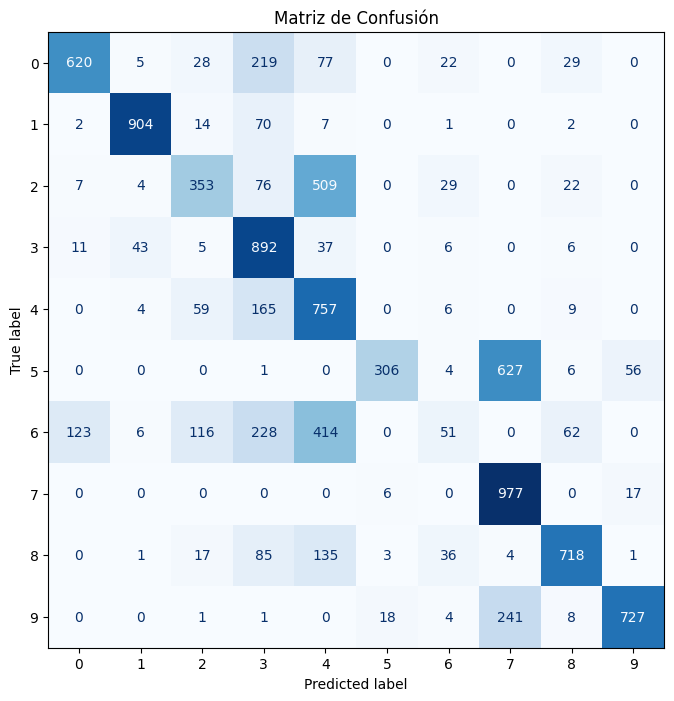

In [15]:
# Importaciones adicionales necesarias
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Definir transformador de identidad para opción sin escalado
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X

# Pipeline para Naive Bayes
nb_pipeline = Pipeline([
    ('scaler', IdentityTransformer()),  # Por defecto sin escalado
    ('nb', GaussianNB())
])

# Parámetros para GridSearch
param_grid = {
    'scaler': [StandardScaler(), IdentityTransformer()],  # Probar con y sin escalado
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Valores para suavizado
}

# GridSearch
grid_search = GridSearchCV(
    nb_pipeline, 
    param_grid, 
    cv=3,  # 3-fold CV para eficiencia
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo
print("Entrenando Naive Bayes con GridSearch...")
grid_search.fit(X_train_flat, y_train)

# Mejor modelo
best_nb_model = grid_search.best_estimator_

# Predecir
y_pred = best_nb_model.predict(X_test_flat)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
class_report = classification_report(y_test, y_pred, output_dict=True)

# Crear ModelData
nb_model_data = ModelData(
    model=best_nb_model,
    metrics={
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'class_report': class_report
    },
    X_test=X_test_flat,
    y_test=y_test
)

# Generar matriz de confusión
try:
    nb_model_data.generate_confusion_matrix()
except Exception as e:
    print(f"Error generando matriz de confusión: {e}")

# Añadir a resultados
model_results.append(nb_model_data)

# Imprimir resultados
print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_:.4f}")
print(f"Precisión en prueba: {accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# No mostrar la matriz de confusión nuevamente para evitar duplicación
# La matriz ya se mostró en generate_confusion_matrix()

## Parte 3: Redes Neuronales

3.1 Red Neuronal Simple (Dense) — 10 pts
- Arquitectura sugerida:
  - Input: 784 neuronas (imágenes aplanadas)
  - Dense 128 + ReLU
  - Dense 64 + ReLU
  - Dense 10 + Softmax
- Usar `categorical_crossentropy` y métricas de accuracy.

3.2 Red Convolucional (CNN) — 20 pts
- Arquitectura sugerida:
  - Conv2D(32, 3x3) + ReLU + MaxPooling
  - Conv2D(64, 3x3) + ReLU + MaxPooling
  - Flatten
  - Dense(128) + ReLU + Dropout(0.5)
  - Dense(10) + Softmax
- Aplicar data augmentation como bonus opcional.

Entregables:
- Implementación de ambas redes.
- Gráficas de loss y accuracy durante entrenamiento.
- Evaluación en el conjunto de prueba y análisis de overfitting/underfitting.

In [ ]:
# Importaciones necesarias para SciKeras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping  # Añadir EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Función para crear el modelo
def create_dense_model(
    meta,
    learning_rate=0.001, 
    dropout_rate=0.0, 
    activation='relu', 
    neurons_layer1=128, 
    neurons_layer2=64,
    **kwargs
):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    
    model = Sequential([
        Input(shape=(n_features_in_,)),
        Dense(neurons_layer1, activation=activation),
        Dropout(dropout_rate),
        Dense(neurons_layer2, activation=activation),
        Dropout(dropout_rate),
        Dense(n_classes_, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Crear el wrapper de Keras para scikit-learn usando SciKeras
dense_model = KerasClassifier(
    model=create_dense_model,
    learning_rate=0.001,
    dropout_rate=0.0,
    activation='relu',
    neurons_layer1=128,
    neurons_layer2=64,
    verbose=0,
    target_type="multiclass"
)

# Definir los parámetros para GridSearch
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'model__dropout_rate': [0.0, 0.2],  # Añadido 0.5 para más regularización
    'model__activation': ['relu'],
    'model__neurons_layer1': [128, 256],
    'model__neurons_layer2': [64, 128],  # Añadido 128 como opción adicional
    'epochs': [50],  # Aumentado para permitir que early stopping funcione
    'batch_size': [64, 128]  # Añadido 64 como opción adicional
}

# Realizar GridSearch
print("Realizando GridSearch para Red Neuronal Densa...")
grid_search_dense = GridSearchCV(
    estimator=dense_model,
    param_grid=param_grid,
    cv=3,  # Aumentado a 3 folds para mejor evaluación
    scoring='accuracy',
    verbose=1,
    n_jobs=1
)

# Ajustar el modelo
grid_search_dense.fit(X_train_flat, y_train)

# Obtener los mejores parámetros
best_params = grid_search_dense.best_params_

# Extraer parámetros para el modelo y parámetros de entrenamiento
model_params = {}
fit_params = {}
for key, value in best_params.items():
    if key.startswith('model__'):
        model_params[key[7:]] = value
    else:
        fit_params[key] = value

# Crear un nuevo modelo con los mejores parámetros
best_dense_model = KerasClassifier(
    model=create_dense_model,
    **model_params,
    verbose=0,
    target_type="multiclass"
)

# Definir Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Número de épocas sin mejora antes de detener
    restore_best_weights=True,  # Restaurar los pesos del mejor modelo
    min_delta=0.001,  # Cambio mínimo para considerar como mejora
    verbose=1
)

# Reentrenar el mejor modelo con Early Stopping y validación
history_dense = best_dense_model.fit(
    X_train_flat, y_train,
    validation_split=0.2,
    callbacks=[early_stopping],
    **fit_params
)

# Hacer predicciones
y_pred = best_dense_model.predict(X_test_flat)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
class_report = classification_report(y_test, y_pred, output_dict=True)

# Crear diccionario de métricas
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'class_report': class_report
}

# Crear instancia de ModelData
dense_model_data = ModelData(
    model=best_dense_model,
    metrics=metrics,
    X_test=X_test_flat,
    y_test=y_test
)

# Generar todos los plots
dense_model_data.generate_all_plots()

# Almacenar en el array de resultados
model_results.append(dense_model_data)

# Mostrar resultados
print(f"\nMejores parámetros: {grid_search_dense.best_params_}")
print(f"Mejor puntuación de validación cruzada: {grid_search_dense.best_score_:.4f}")
print(f"Precisión en conjunto de prueba: {accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Épocas de entrenamiento efectivas: {len(history_dense.history['loss'])}")

# Mostrar la matriz de confusión si se generó
if 'confusion_matrix' in dense_model_data.plots:
    plt.figure(dense_model_data.plots['confusion_matrix'].number)
    plt.show()

# ---------- Curvas de entrenamiento (loss / accuracy) ----------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dense.history.get('loss', []), label='train_loss')
plt.plot(history_dense.history.get('val_loss', []), label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Dense - Loss')

plt.subplot(1, 2, 2)
# Keras puede usar 'accuracy' o 'acc' dependiendo de la versión
acc_key = 'accuracy' if 'accuracy' in history_dense.history else 'acc'
val_acc_key = 'val_' + acc_key
plt.plot(history_dense.history.get(acc_key, []), label='train_acc')
plt.plot(history_dense.history.get(val_acc_key, []), label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Dense - Accuracy')
plt.tight_layout()
plt.show()

Realizando GridSearch para Red Neuronal Densa...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


KeyboardInterrupt: 

In [17]:
# Importaciones necesarias para la CNN
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

# Usar los datos ya preprocesados (normalizados y en formato de imagen)
print("Usando datos preprocesados para CNN...")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")

# Añadir dimensión de canal para CNN (de (28, 28) a (28, 28, 1))
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1)

print(f"Forma de X_train_cnn: {X_train_cnn.shape}")
print(f"Forma de X_test_cnn: {X_test_cnn.shape}")
print(f"Rango de valores: [{X_train_cnn.min():.3f}, {X_train_cnn.max():.3f}]")

# Función para crear el modelo CNN
def create_cnn_model(
    meta,
    learning_rate=0.001,
    dropout_rate=0.5,
    filters_layer1=32,
    filters_layer2=64,
    dense_neurons=128,
    **kwargs
):
    input_shape = meta["X_shape_"][1:]  # Obtener forma de entrada (28, 28, 1)
    
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(filters_layer1, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Conv2D(filters_layer2, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(meta["n_classes_"], activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',  # Usamos etiquetas enteras, no one-hot
        metrics=['accuracy']
    )
    return model

# Crear el wrapper de Keras para scikit-learn
cnn_model = KerasClassifier(
    model=create_cnn_model,
    learning_rate=0.001,
    dropout_rate=0.5,
    filters_layer1=32,
    filters_layer2=64,
    dense_neurons=128,
    verbose=0,
    target_type="multiclass"
)

# Definir los parámetros para GridSearch
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'model__dropout_rate': [0.3, 0.5],
    'model__filters_layer1': [32, 64, 128],
    'model__filters_layer2': [64, 128, 256],
    'model__dense_neurons': [128, 256, 512],
    'epochs': [50],
    'batch_size': [64, 128]
}

# Realizar GridSearch
print("\nRealizando GridSearch para Red Neuronal Convolucional...")
grid_search_cnn = GridSearchCV(
    estimator=cnn_model,
    param_grid=param_grid,
    cv=3,  # 3 folds para mejor evaluación
    scoring='accuracy',
    verbose=1,
    n_jobs=1  # Keras no soporta paralelismo con n_jobs > 1
)

# Ajustar el modelo
grid_search_cnn.fit(X_train_cnn, y_train)  # Usar y_train (etiquetas enteras)

# Obtener los mejores parámetros
best_params = grid_search_cnn.best_params_
print(f"\nMejores parámetros encontrados: {best_params}")

# Extraer parámetros para el modelo y parámetros de entrenamiento
model_params = {}
fit_params = {}
for key, value in best_params.items():
    if key.startswith('model__'):
        model_params[key[7:]] = value
    else:
        fit_params[key] = value

# Crear un nuevo modelo con los mejores parámetros
best_cnn_model = KerasClassifier(
    model=create_cnn_model,
    **model_params,
    verbose=0,
    target_type="multiclass"
)

# Definir Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

# Reentrenar el mejor modelo con Early Stopping
print("\nReentrenando el mejor modelo con Early Stopping...")
history_cnn = best_cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    callbacks=[early_stopping],
    **fit_params
)

# Hacer predicciones
y_pred = best_cnn_model.predict(X_test_cnn)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
class_report = classification_report(y_test, y_pred, output_dict=True)

# Crear diccionario de métricas
metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'class_report': class_report
}

# Crear instancia de ModelData
cnn_model_data = ModelData(
    model=best_cnn_model,
    metrics=metrics,
    X_test=X_test_cnn,
    y_test=y_test
)

# Generar todos los plots
cnn_model_data.generate_all_plots()

# Almacenar en el array de resultados
model_results.append(cnn_model_data)

# Mostrar resultados
print(f"\n=== RESULTADOS DEL MODELO CNN ===")
print(f"Mejor puntuación de validación cruzada: {grid_search_cnn.best_score_:.4f}")
print(f"Precisión en conjunto de prueba: {accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Épocas de entrenamiento efectivas: {len(history_cnn.history['loss'])}")

# Mostrar la matriz de confusión si se generó
if 'confusion_matrix' in cnn_model_data.plots:
    plt.figure(cnn_model_data.plots['confusion_matrix'].number)
    plt.show()

# ---------- Curvas de entrenamiento (loss / accuracy) ----------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history.get('loss', []), label='train_loss')
plt.plot(history_cnn.history.get('val_loss', []), label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CNN - Curva de Pérdida')

plt.subplot(1, 2, 2)
# Keras puede usar 'accuracy' o 'acc' dependiendo de la versión
acc_key = 'accuracy' if 'accuracy' in history_cnn.history else 'acc'
val_acc_key = 'val_' + acc_key
plt.plot(history_cnn.history.get(acc_key, []), label='train_acc')
plt.plot(history_cnn.history.get(val_acc_key, []), label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN - Curva de Precisión')
plt.tight_layout()
plt.show()

# Visualización de la arquitectura del modelo
print("\nResumen de la arquitectura del modelo CNN:")
best_cnn_model.model_.summary()

# Visualizar algunas predicciones
print("\nVisualizando algunas predicciones...")
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i], cmap='gray')
    pred_label = y_pred[i]
    true_label = y_test[i]
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

Usando datos preprocesados para CNN...
Forma de X_train: (60000, 28, 28)
Forma de X_test: (10000, 28, 28)
Forma de X_train_cnn: (60000, 28, 28, 1)
Forma de X_test_cnn: (10000, 28, 28, 1)
Rango de valores: [0.000, 1.000]

Realizando GridSearch para Red Neuronal Convolucional...
Fitting 3 folds for each of 216 candidates, totalling 648 fits


KeyboardInterrupt: 